<a href="https://colab.research.google.com/github/netiahlad/BIOENG2049/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6
Ahlad Neti | BIOENG 2049 | 29 April 2021

## Importing Libraries and Data

In [55]:
#import various useful packages
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import pandas as pd
import seaborn
import cv2
import os
import scipy.io as scio
from scipy.signal import welch, get_window
from scipy import stats
#%matplotlib inline

#importing dimensionality reduction packages
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, RocCurveDisplay, plot_confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import spectral_clustering
from sklearn.manifold import MDS
from sklearn.manifold import Isomap 
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import img_to_graph
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.neural_network import MLPClassifier as MLP

#importing clustering packages
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans as KM
from sklearn.linear_model import LogisticRegression as LR

#other packages
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from itertools import cycle
from mpl_toolkits import mplot3d


# please enter the address of input file "session4_train_2018.mat"
path = r'/content/drive/MyDrive/BIOE2390/Assignment 6/EEG_sleep.mat'
data = scio.loadmat(path)

raw = np.array(data['EEG'][0][0][0])
labels = np.array(data['EEG'][0][0][1])
fs = np.array(data['EEG'][0][0][2])
time = np.array(np.transpose(range(len(raw))/fs))
fs = 500

## Visualizing EEG Signal Data

Text(0, 0.5, 'Voltage (mV)')

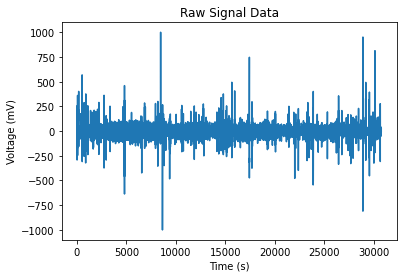

In [56]:
fig = plt.figure()
plt.plot(time,raw)
plt.title("Raw Signal Data")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")

The signal data ranges from -1000 to 1000 mV, with most of the data in the range of +/- 500. There seem to be some general distinguishability, but it is hard to say with just the raw data. 

Text(0, 0.5, 'Voltage (mV)')

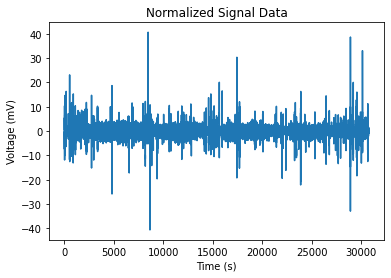

In [57]:
signal = (raw-np.mean(raw))/np.std(raw)
fig = plt.figure()
plt.plot(time,signal)
plt.title("Normalized Signal Data")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")

When we normalize the data, it falls in the range of +/- 40 with most of the data between +/-20. 

## Creating Epochs and Computing PSD

In [58]:
S = signal.flatten()
col = []
epoch_label = []
delta = []
theta = []
alpha = []
beta = []
step = 30
i=0

for c in range(round(len(S)/(fs*step))):
  segment = S[(fs*i):(fs*(i+step))]
  epoch_label.append(stats.mode(labels[(fs*i):(fs*(i+step))])[0][0][0])
  col.append(segment)
  i += step
  freq, psd = welch(segment,window=get_window('hamming',step*fs),fs=fs,noverlap=0)
  total_energy = np.trapz(psd[0:35], range(0, 35))
  delta.append(np.trapz(psd[0:4], range(0, 4)) / total_energy)
  theta.append(np.trapz(psd[5:8], range(5, 8)) / total_energy)
  alpha.append(np.trapz(psd[9:13], range(9, 13)) / total_energy)
  beta.append(np.trapz(psd[14:35], range(14, 35)) / total_energy)


delta_n = (delta-np.average(delta))/np.std(delta)
theta_n = (theta-np.average(theta))/np.std(theta)
alpha_n = (alpha-np.average(alpha))/np.std(alpha)
beta_n = (beta-np.average(beta))/np.std(beta) 

raw_df = pd.DataFrame(col)
raw_df['Sleep Stage'] = epoch_label
print(raw_df.shape)
raw_df.head()

(1026, 15001)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14961,14962,14963,14964,14965,14966,14967,14968,14969,14970,14971,14972,14973,14974,14975,14976,14977,14978,14979,14980,14981,14982,14983,14984,14985,14986,14987,14988,14989,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999,Sleep Stage
0,-0.111304,-0.257174,-0.469002,-0.547645,-0.315522,0.109404,0.437929,0.541941,0.455687,0.234979,0.010466,-0.037734,0.013003,-0.044077,-0.206436,-0.234342,-0.068177,0.024419,-0.160773,-0.508324,-0.692247,-0.651657,-0.510861,-0.370064,-0.217852,0.028224,0.314891,0.614241,0.892029,1.045509,1.072146,1.009993,0.874271,0.662442,0.370702,0.030761,-0.292690,-0.550182,-0.707468,-0.805138,...,4.801346,4.730314,4.797541,4.982733,5.027128,4.833057,4.574296,4.238161,3.846215,3.527837,3.402262,3.496126,3.791672,4.173471,4.507069,4.655476,4.611081,4.503264,4.396715,4.338367,4.508338,4.954827,5.408927,5.663882,5.690519,5.538307,5.335358,5.311257,5.524354,5.746331,5.813558,5.627098,5.266862,4.916774,4.693529,4.626302,4.721435,5.018249,5.393706,5
1,5.635977,5.539576,5.118455,4.720166,4.626302,4.781051,4.957364,5.091818,5.264325,5.474885,5.674030,5.824974,5.828779,5.653735,5.374679,5.155240,5.166656,5.402585,5.751404,5.977186,5.894738,5.656272,5.554797,5.660077,5.770431,5.767894,5.774236,5.821168,5.615682,5.132408,4.739193,4.665624,4.841936,5.098160,5.360726,5.506596,5.412732,5.099429,4.675771,4.363736,...,1.417161,1.292854,1.191379,0.997309,0.723327,0.474713,0.336454,0.360554,0.574920,0.921203,1.261143,1.508488,1.680995,1.810376,1.878871,1.831939,1.663237,1.436187,1.198990,0.980819,0.828607,0.744890,0.714448,0.729669,0.804507,0.966866,1.202795,1.395597,1.470435,1.493267,1.476777,1.391792,1.234506,1.011262,0.793091,0.590141,0.440466,0.406218,0.483592,5
2,0.638342,0.781675,0.873002,0.969403,1.114005,1.342323,1.555420,1.569373,1.376571,1.116542,0.923740,0.774064,0.634536,0.520377,0.493740,0.578725,0.762648,0.989698,1.198990,1.377839,1.504683,1.519904,1.403208,1.230701,1.116542,1.007456,0.793091,0.544477,0.392265,0.403681,0.515303,0.697958,0.908518,1.130494,1.299196,1.414624,1.484388,1.470435,1.370229,1.239580,...,0.784212,0.807043,0.861586,0.824802,0.709374,0.709374,0.892029,1.124152,1.253533,1.101320,0.742353,0.435392,0.299669,0.260348,0.251469,0.278106,0.356749,0.440466,0.599020,0.961793,1.451409,1.787544,1.914388,1.977809,1.883945,1.613768,1.387987,1.252264,1.108931,0.946571,0.785480,0.651026,0.503887,0.495008,0.569846,0.495008,0.269227,0.169021,0.307280,5
3,0.491203,0.560967,0.571115,0.663710,0.864123,1.078489,1.204064,1.264949,1.297928,1.149521,0.774064,0.415097,0.248932,0.254006,0.332649,0.252737,0.010466,-0.082130,0.058667,0.347870,0.606631,0.676395,0.604094,0.558430,0.725864,1.022677,1.226896,1.291586,1.309344,1.342323,1.325834,1.115273,0.779138,0.493740,0.246395,-0.027587,-0.286348,-0.499445,-0.619946,-0.514666,...,0.280643,0.132236,-0.134136,-0.432218,-0.626288,-0.598383,-0.395433,-0.229268,-0.189947,-0.217852,-0.244489,-0.239416,-0.249563,-0.351038,-0.504519,-0.529887,-0.321864,-0.041540,0.167752,0.248932,0.157605,0.014271,0.035835,0.125894,0.104330,0.010466,-0.079593,-0.159504,-0.221658,-0.297764,-0.405581,-0.420802,-0.244489,0.032030,0.257811,0.425244,0.439197,0.200731,-0.143015,5
4,-0.460123,-0.697321,-0.821627,-0.825433,-0.723958,-0.575551,-0.465197,-0.408118,-0.357380,-0.243221,-0.047882,0.238784,0.597752,0.820996,0.725864,0.427781,0.204537,0.084035,-0.078324,-0.259711,-0.314253,-0.272395,-0.258442,-0.271127,-0.378944,-0.637704,-0.949739,-1.150152,-1.148884,-0.989061,-0.779769,-0.618678,-0.565404,-0.638973,-0.762011,-0.803869,-0.706200,-0.465197,-0.215315,-0.080861,...,-0.706200,-0.882512,-0.986524,-1.101952,-1.188205,-1.138736,-0.947203,-0.802601,-0.756937,-0.753132,-0.704931,-0.575551,-0.370064,-0.103693,0.038372,-0.088472,-0.368796,-0.553988,-0.432218,-0.080861,0.247664,0.341528,0.155068,-0.042808,-0.112572,-0.121451,-0.134136,-0.235610,-0.416997,-0.567940,-0.590772,-0.5856

Text(0, 0.5, 'Relative Power (%)')

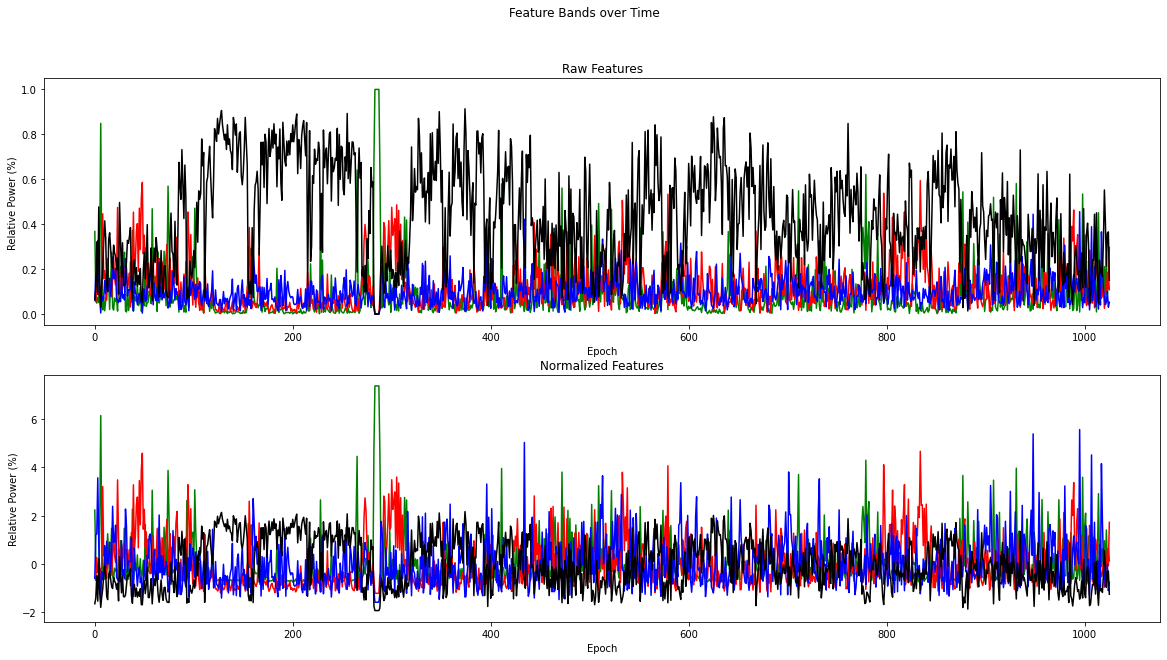

In [59]:
epochs = range(len(delta))

fig = plt.figure(figsize=(20,10))
fig.suptitle("Feature Bands over Time")

ax = fig.add_subplot(2,1,1)
ax.plot(epochs,delta,'g')
ax.plot(epochs,theta,'r')
ax.plot(epochs,alpha,'b')
ax.plot(epochs,beta,'k')
ax.set_title('Raw Features')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

ax = fig.add_subplot(2,1,2)
ax.plot(epochs,delta_n,'g')
ax.plot(epochs,theta_n,'r')
ax.plot(epochs,alpha_n,'b')
ax.plot(epochs,beta_n,'k')
ax.set_title('Normalized Features')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

We can see that in general, the relative power in each of the frequency bands is between 0 and 1. However, the specific range is different between the bands. By normalizing the data, it is easier to compare and see differences between the bands. While the data is normalized, there do appear to be a great number of outliers. This may heavily impact the prediction of the data. 

Text(0, 0.5, 'Relative Power (%)')

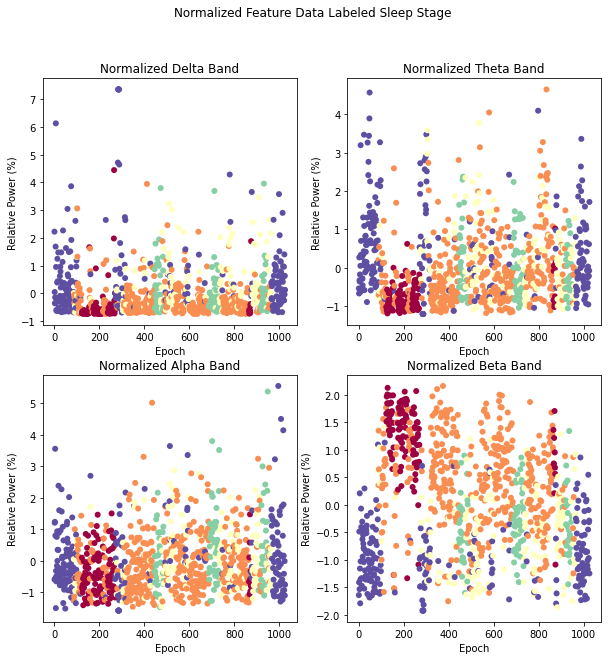

In [60]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Normalized Feature Data Labeled Sleep Stage')

ax = fig.add_subplot(2,2,1)
ax.scatter(epochs,delta_n,c=epoch_label,edgecolor="none",cmap='Spectral')
ax.set_title('Normalized Delta Band')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

ax = fig.add_subplot(2,2,2)
ax.scatter(epochs,theta_n,c=epoch_label,edgecolor="none",cmap='Spectral')
ax.set_title('Normalized Theta Band')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

ax = fig.add_subplot(2,2,3)
ax.scatter(epochs,alpha_n,c=epoch_label,edgecolor="none",cmap='Spectral')
ax.set_title('Normalized Alpha Band')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

ax = fig.add_subplot(2,2,4)
ax.scatter(epochs,beta_n,c=epoch_label,edgecolor="none",cmap='Spectral')
ax.set_title('Normalized Beta Band')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative Power (%)')

When we plot the relative powers in each band with the stage of sleep, we cansee that there is some difference between the colors. This is most apparent in the Beta and Theta bands. There seems to be a little distinguishability in Delta and Alpha, but it is much harder to see for certain. 

In [61]:
f_df = pd.DataFrame()
f_df['Delta'] = delta_n
f_df['Theta'] = theta_n
f_df['Alpha'] = alpha_n
f_df['Beta'] = beta_n


df = pd.DataFrame()
df['Delta'] = delta_n
df['Theta'] = theta_n
df['Alpha'] = alpha_n
df['Beta'] = beta_n
df['Sleep Stage'] = epoch_label

Text(0.5, 1.0, 'Beta')

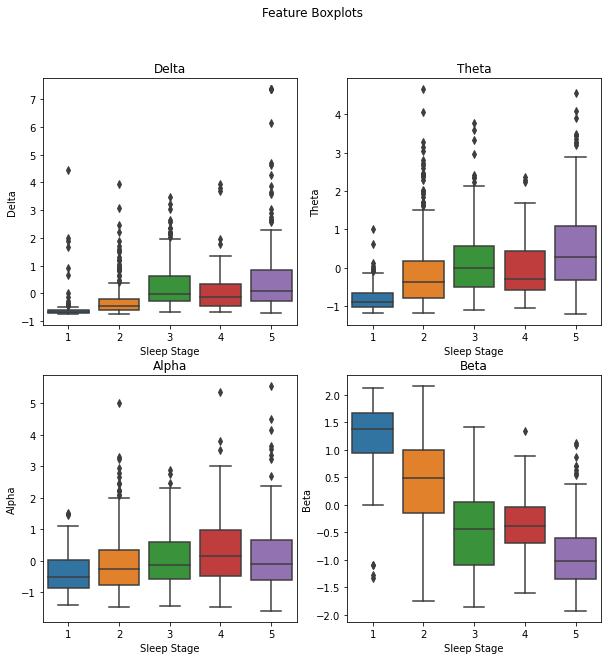

In [62]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Feature Boxplots')

plt.subplot(2,2,1)
seaborn.boxplot(y='Delta',x='Sleep Stage',data=df)
plt.title('Delta')

plt.subplot(2,2,2)
seaborn.boxplot(y='Theta',x='Sleep Stage',data=df)
plt.title('Theta')

plt.subplot(2,2,3)
seaborn.boxplot(y='Alpha',x='Sleep Stage',data=df)
plt.title('Alpha')

plt.subplot(2,2,4)
seaborn.boxplot(y='Beta',x='Sleep Stage',data=df)
plt.title('Beta')


From the boxplots grouped by the sleep stage, we can see that the Beta band does have the most differences between classes in terms of distribution. Delta and Theta are also decent, whereas Alpha is not very different between groups. We can also see the large number of outliers in the data with the boxplots. 
From this preliminary analysis, I beileve that Beta will be the most important feature in the prediction of sleep stage, followed by Delta, Theta, and then Alpha is last.  

In [63]:
awake = []
for k in epoch_label:
  if k == 5:
    awake.append(1)
  else:
    awake.append(0)

df['Awake'] = awake
df.head()

,Delta,Theta,Alpha,Beta,Sleep Stage,Awake
0,2.224838,-0.541133,-0.591079,-1.642087,5,1
1,0.049522,-0.673060,1.208047,-1.410523,5,1
2,-0.358729,0.268214,1.235774,-0.485605,5,1
3,-0.145350,-0.327934,3.554516,-1.534847,5,1
4,-0.341076,-0.363065,0.801702,0.209201,5,1


## Binary (Awake/Asleep) Classification

Text(0.5, 1.0, 'Beta')

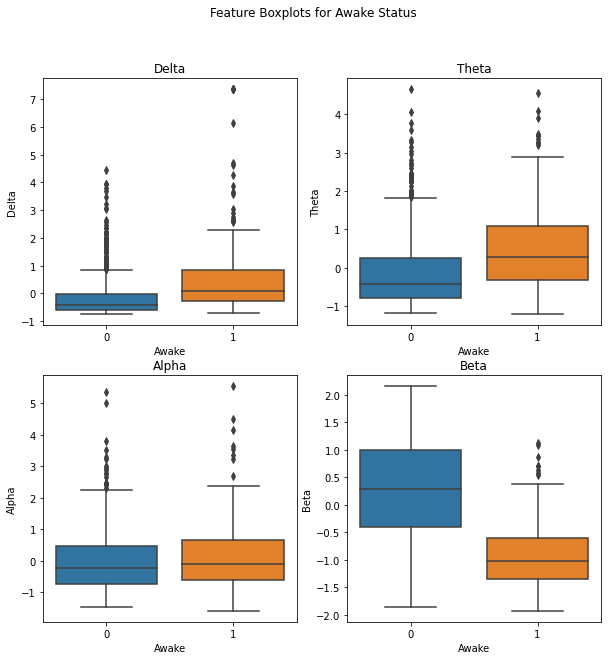

In [64]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Feature Boxplots for Awake Status')

plt.subplot(2,2,1)
seaborn.boxplot(y='Delta',x='Awake',data=df)
plt.title('Delta')

plt.subplot(2,2,2)
seaborn.boxplot(y='Theta',x='Awake',data=df)
plt.title('Theta')

plt.subplot(2,2,3)
seaborn.boxplot(y='Alpha',x='Awake',data=df)
plt.title('Alpha')

plt.subplot(2,2,4)
seaborn.boxplot(y='Beta',x='Awake',data=df)
plt.title('Beta')

If we are just looking at the binary (sleep vs wake) classes, we see the same trends in distinguishability. The Beta band is the most different between classes, where as the Alpha band has no difference between classes. 

Text(0.5, 1.0, 'LDA Projections')

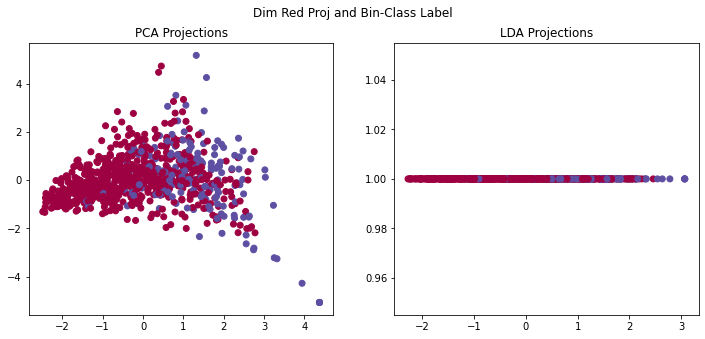

In [65]:
X_train, X_test, y_train, y_test = train_test_split(f_df, awake, test_size=0.25, random_state=42)

fig = plt.figure(figsize=(12,5))
fig.suptitle("Dim Red Proj and Bin-Class Label")

pca = PCA()
pca_proj = pca.fit_transform(X_train,y_train)
plt.subplot(1,2,1)
plt.scatter(pca_proj[:,0],pca_proj[:,1],c=y_train,cmap='Spectral');
plt.title("PCA Projections")

lda = LDA()
lda_proj = lda.fit_transform(X_train,y_train)
plt.subplot(1,2,2)
plt.scatter(lda_proj[:,0],np.ones(len(lda_proj)),c=y_train,cmap='Spectral');
plt.title("LDA Projections")

When we plot the PCA and LDA projections of the features, we can see that there is some clustering of the classes. There may be a linear decision boundary available for both PCA and LDA. All 4 PCA projections were used in the classification, whereas LDA outputed only one projection. 

Text(0.5, 1.0, 'Raw Test')

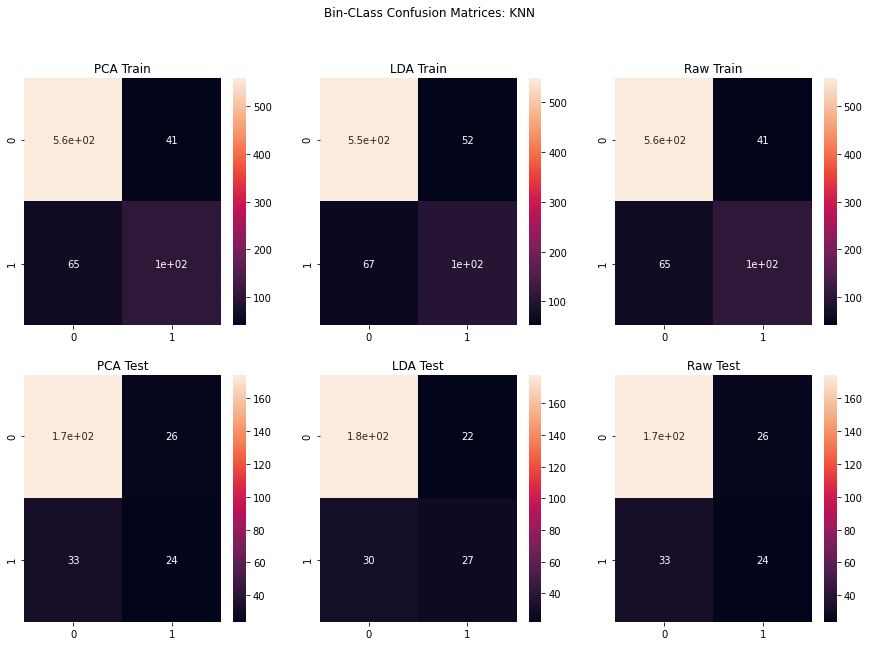

In [66]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Bin-CLass Confusion Matrices: KNN')

knn_pca = KNN(n_neighbors=5)
knn_pca.fit(pca_proj,y_train)
knn_pca_awake = knn_pca.predict(pca_proj)
cm = confusion_matrix(y_train,knn_pca_awake)
plt.subplot(2,3,1)
seaborn.heatmap(cm,annot=True)
plt.title('PCA Train')

knn_lda = KNN(n_neighbors=5)
knn_lda.fit(lda_proj,y_train)
knn_lda_awake = knn_lda.predict(lda_proj)
cm = confusion_matrix(y_train,knn_lda_awake)
plt.subplot(2,3,2)
seaborn.heatmap(cm,annot=True)
plt.title('LDA Train')

knn_raw = KNN(n_neighbors=5)
knn_raw.fit(X_train,y_train)
knn_raw_awake = knn_raw.predict(X_train)
cm = confusion_matrix(y_train,knn_raw_awake)
plt.subplot(2,3,3)
seaborn.heatmap(cm,annot=True)
plt.title('Raw Train')

plt.subplot(2,3,4)
knn_pca_awake_test = knn_pca.predict(pca.transform(X_test))
cm = confusion_matrix(y_test,knn_pca_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('PCA Test')

plt.subplot(2,3,5)
knn_lda_awake_test = knn_lda.predict(lda.transform(X_test))
cm = confusion_matrix(y_test,knn_lda_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('LDA Test')

plt.subplot(2,3,6)
knn_raw_awake_test = knn_raw.predict(X_test)
cm = confusion_matrix(y_test,knn_raw_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('Raw Test')

Using a 75/25 training/testing ratio, I used a K-Nearest Neighbor classifier to predict the awake vs asleep state. Both confusion matrices and classification reports were genereated. We can see visually from the confusion matrices of the training and testing validation did pretty well in predicting awake vs asleep. PCA, LDA, and the Raw data all had similar numbers in the matrix. This indicates that there was likely no overfitting. The training and testing accuracies seem similar, at least visually. 

(0.5, 0.85)

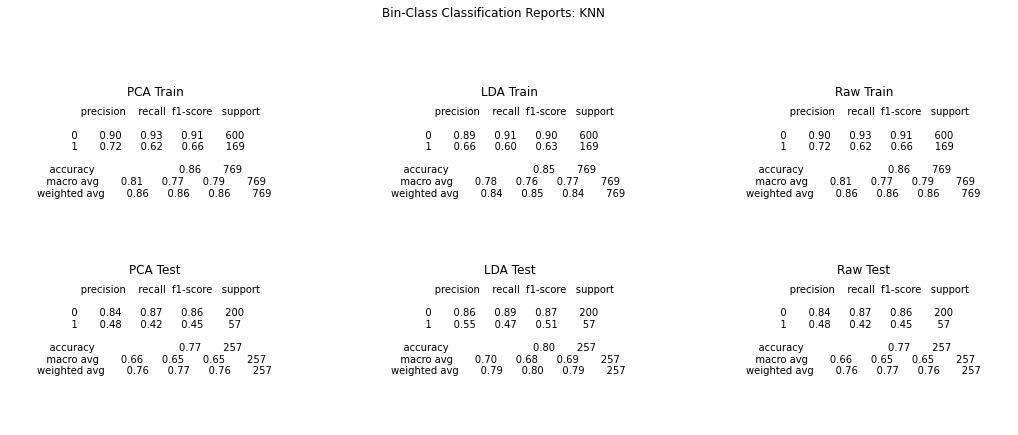

In [67]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('Bin-Class Classification Reports: KNN',y=1.1)

cr = classification_report(y_train,knn_pca_awake)
plt.subplot(2,3,1)
plt.text(0.1,0.6,str(cr))
plt.title('PCA Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_train,knn_lda_awake)
plt.subplot(2,3,2)
plt.text(0.1,0.6,str(cr))
plt.title('LDA Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_train,knn_raw_awake)
plt.subplot(2,3,3)
plt.text(0.1,0.6,str(cr))
plt.title('Raw Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_pca_awake_test)
plt.subplot(2,3,4)
plt.text(0.1,0.6,str(cr))
plt.title('PCA Test')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_lda_awake_test)
plt.subplot(2,3,5)
plt.text(0.1,0.6,str(cr))
plt.title('LDA Test')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_raw_awake_test)
plt.subplot(2,3,6)
plt.text(0.1,0.6,str(cr))
plt.title('Raw Test')
plt.axis('off')
plt.ylim([0.5,0.85])

By outputting the classification report, we can see the calculated precision and recall for training and testing data on the pca, lda, and raw features. We can see that there is around an 80% accuracy for training and a 70% accuracy for testing. It is interesting to note that PCA and the Raw data did better than LDA on training than testing, whereas LDA did better than the others in testing. 
This indicates that PCA, LDA, or the Raw data can be used to successfully predict awake vs asleep with around a 70% accuracy. 

## Multi-Class Classification

Next, we will try a multi-class classification with the 5 sleep stages. We are once again using a 75/25 training/testing data split, and a KNN classifier. 

Text(0.5, 1.0, 'LDA Projections')

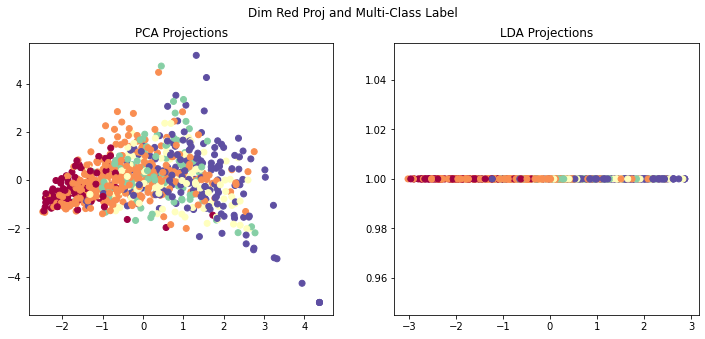

In [68]:
X_train, X_test, y_train, y_test = train_test_split(f_df, epoch_label, test_size=0.25, random_state=42)

fig = plt.figure(figsize=(12,5))
fig.suptitle("Dim Red Proj and Multi-Class Label")

pca = PCA()
pca_proj = pca.fit_transform(X_train,y_train)
plt.subplot(1,2,1)
plt.scatter(pca_proj[:,0],pca_proj[:,1],c=y_train,cmap='Spectral');
plt.title("PCA Projections")

lda = LDA()
lda_proj = lda.fit_transform(X_train,y_train)
plt.subplot(1,2,2)
plt.scatter(lda_proj[:,0],np.ones(len(lda_proj)),c=y_train,cmap='Spectral');
plt.title("LDA Projections")

When we label by the sleep stage, it becomes much harder to detect a linear decision boundary in either the PCA or LDA projections. This may be difficult for multi-class prediction. 

Text(0.5, 1.0, 'Raw Test')

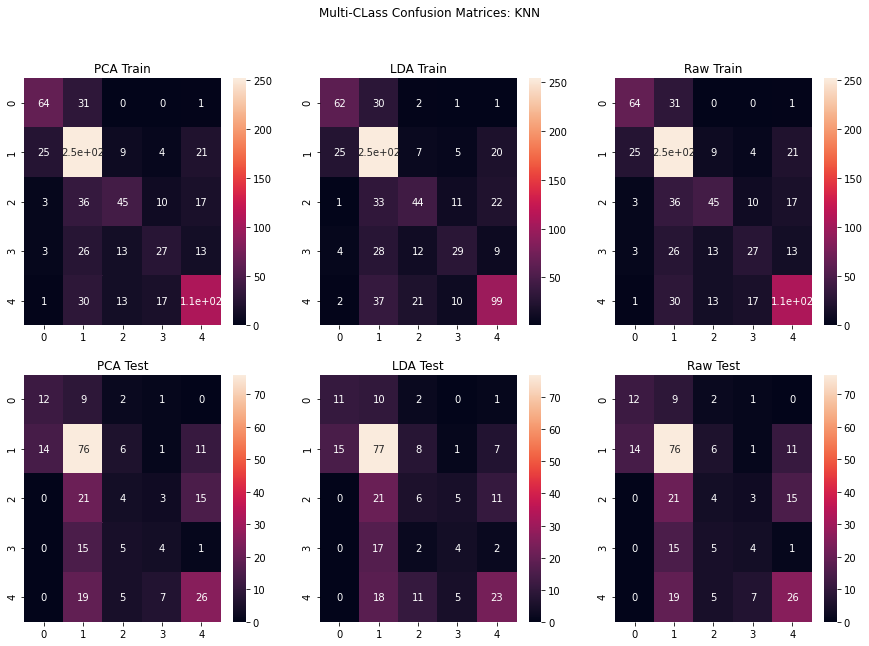

In [69]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Multi-CLass Confusion Matrices: KNN')

knn_pca = KNN(n_neighbors=5)
knn_pca.fit(pca_proj,y_train)
knn_pca_awake = knn_pca.predict(pca_proj)
cm = confusion_matrix(y_train,knn_pca_awake)
plt.subplot(2,3,1)
seaborn.heatmap(cm,annot=True)
plt.title('PCA Train')

knn_lda = KNN(n_neighbors=5)
knn_lda.fit(lda_proj,y_train)
knn_lda_awake = knn_lda.predict(lda_proj)
cm = confusion_matrix(y_train,knn_lda_awake)
plt.subplot(2,3,2)
seaborn.heatmap(cm,annot=True)
plt.title('LDA Train')

knn_raw = KNN(n_neighbors=5)
knn_raw.fit(X_train,y_train)
knn_raw_awake = knn_raw.predict(X_train)
cm = confusion_matrix(y_train,knn_raw_awake)
plt.subplot(2,3,3)
seaborn.heatmap(cm,annot=True)
plt.title('Raw Train')

plt.subplot(2,3,4)
knn_pca_awake_test = knn_pca.predict(pca.transform(X_test))
cm = confusion_matrix(y_test,knn_pca_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('PCA Test')

plt.subplot(2,3,5)
knn_lda_awake_test = knn_lda.predict(lda.transform(X_test))
cm = confusion_matrix(y_test,knn_lda_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('LDA Test')

plt.subplot(2,3,6)
knn_raw_awake_test = knn_raw.predict(X_test)
cm = confusion_matrix(y_test,knn_raw_awake_test)
seaborn.heatmap(cm,annot=True)
plt.title('Raw Test')

We can see that in general the performance of both training and testing was not as good as the binary class prediction. However, the training validation is much better compared to the testing for the multi-class, indicating that there may have been some overfitting. Specifically, the testing data seemed to prefer stage 1 sleep over the others, as most of the predictions were for stage 1. 

(0.5, 0.85)

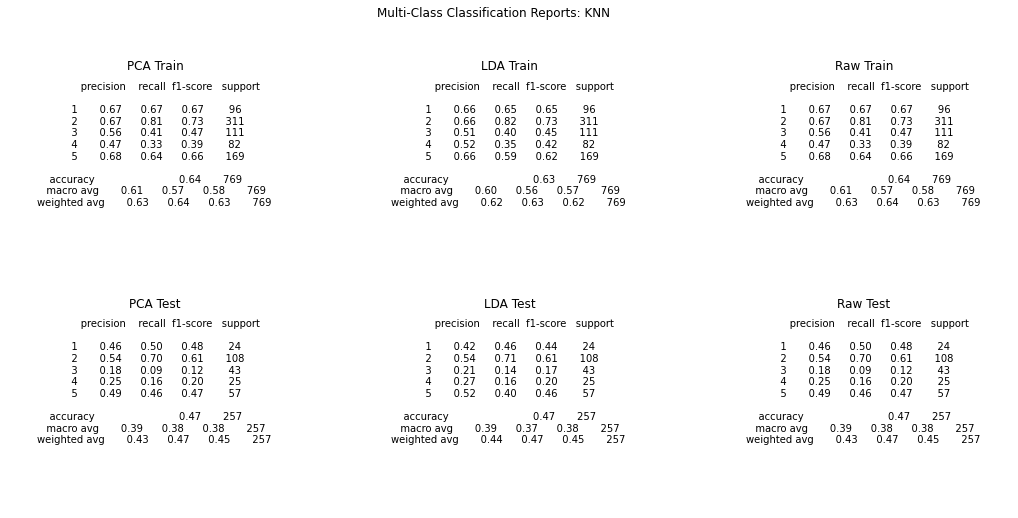

In [70]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Multi-Class Classification Reports: KNN',y=1)

cr = classification_report(y_train,knn_pca_awake)
plt.subplot(2,3,1)
plt.text(0.1,0.6,str(cr))
plt.title('PCA Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_train,knn_lda_awake)
plt.subplot(2,3,2)
plt.text(0.1,0.6,str(cr))
plt.title('LDA Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_train,knn_raw_awake)
plt.subplot(2,3,3)
plt.text(0.1,0.6,str(cr))
plt.title('Raw Train')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_pca_awake_test)
plt.subplot(2,3,4)
plt.text(0.1,0.6,str(cr))
plt.title('PCA Test')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_lda_awake_test)
plt.subplot(2,3,5)
plt.text(0.1,0.6,str(cr))
plt.title('LDA Test')
plt.axis('off')
plt.ylim([0.5,0.85])

cr = classification_report(y_test,knn_raw_awake_test)
plt.subplot(2,3,6)
plt.text(0.1,0.6,str(cr))
plt.title('Raw Test')
plt.axis('off')
plt.ylim([0.5,0.85])

In the multi-class prediction, we achieve about a 60% overall accuracy for the training validation, with individual class accuracy ranging between 40 to 70%. However, the testing validation only achieved overall accuracies of 40%, with indivudal accuracys between 10 and 50%. This heavily implies overfitting of the data. 

From this analysis, we can see that both PCA and LDA projections are effective in the prediction of either sleep vs awake, or the specific sleep stage. However, the raw relative powers are equally as sufficient, so there is no need to perform dimensionality reduction. We can also conclude that the prediction of specifc sleep stage is much more difficult than a binary class. It may be useful to use other frequency ranges as additional features as well. 